In [28]:
import pandas as pd
import sqlite3
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
#incarcam datele
results = pd.read_csv("results.csv")
shootouts = pd.read_csv("shootouts.csv")

In [3]:
def connect_to_database(database_name):
    conn = sqlite3.connect(database_name)
    cursor = conn.cursor()
    return conn, cursor

conn, cursor = connect_to_database('football.db')

results.to_sql('results',conn, if_exists='replace', index=False)
shootouts.to_sql('shootouts', conn, if_exists='replace', index=False)

# Adăugare coloane 'day', 'month' și 'year' în tabela 'results', dacă nu există deja
cursor.execute("""
    PRAGMA table_info(results);
""")
columns = cursor.fetchall()
column_names = [column[1] for column in columns]
if 'day' not in column_names:
    cursor.execute("""
        ALTER TABLE results
        ADD COLUMN day INTEGER;
    """)
if 'month' not in column_names:
    cursor.execute("""
        ALTER TABLE results
        ADD COLUMN month INTEGER;
    """)
if 'year' not in column_names:
    cursor.execute("""
        ALTER TABLE results
        ADD COLUMN year INTEGER;
    """)

# Adăugare coloane 'day', 'month' și 'year' în tabela 'shootouts', dacă nu există deja
cursor.execute("""
    PRAGMA table_info(shootouts);
""")
columns = cursor.fetchall()
column_names = [column[1] for column in columns]
if 'day' not in column_names:
    cursor.execute("""
        ALTER TABLE shootouts
        ADD COLUMN day INTEGER;
    """)
if 'month' not in column_names:
    cursor.execute("""
        ALTER TABLE shootouts
        ADD COLUMN month INTEGER;
    """)
if 'year' not in column_names:
    cursor.execute("""
        ALTER TABLE shootouts
        ADD COLUMN year INTEGER;
    """)

conn.commit()

conn.close()

In [4]:
def extract_date_info(date_str):
    try:
        month, day, year = map(int, date_str.split('/'))
        if year >= 1900:
            return day, month, year
    except ValueError:
        pass

    match = re.match(r'(\d{1,2})-(\d{1,2})-(\d{4})', date_str)
    if match:
        groups = match.groups()
        month, day, year = map(int, (groups[0], groups[1], groups[2]))
        return day, month, year

    match = re.match(r'(\d{4})-(\d{2})-(\d{2})', date_str)
    if match:
        groups = match.groups()
        year, month, day = map(int, (groups[0], groups[1], groups[2]))
        return day, month, year

    return None, None, None

conn = sqlite3.connect('football.db')
cursor = conn.cursor()

# Actualizează valorile pentru coloanele 'day', 'month', 'year' folosind datele extrase
cursor.execute("SELECT date FROM results;")
dates = cursor.fetchall()

for date_row in dates:
    date_str = date_row[0]
    day, month, year = extract_date_info(date_str)
    cursor.execute("UPDATE results SET day=?, month=?, year=? WHERE date=?", (day, month, year, date_str))

# Actualizează valorile pentru coloanele 'day', 'month', 'year' pentru tabela 'shootouts'
cursor.execute("SELECT date FROM shootouts;")
dates_shootouts = cursor.fetchall()

for date_row in dates_shootouts:
    date_str = date_row[0]
    day, month, year = extract_date_info(date_str)
    cursor.execute("UPDATE shootouts SET day=?, month=?, year=? WHERE date=?", (day, month, year, date_str))

cursor.execute("ALTER TABLE results DROP COLUMN date")
cursor.execute("ALTER TABLE shootouts DROP COLUMN date")

cursor.execute("UPDATE shootouts SET first_shooter='Necunoscut' WHERE first_shooter IS NULL")

conn.commit() 

conn.close()

In [5]:
conn = sqlite3.connect('football.db')

df_results = pd.read_sql('SELECT * FROM results', conn)
df_shootouts = pd.read_sql('SELECT * FROM shootouts', conn)

def assign_unique_codes(df, column, start_code):
    unique_codes = {}
    code = start_code
    for value in df[column].unique():
        if pd.notnull(value):  # Ignorăm valorile NaN
            unique_codes[value] = code
            code += 1  # Incrementăm pt val unica
    return unique_codes, code # Returnam si ultimul cod utilizat

# Atribuim coduri unice pentru coloana 'home_team'
unique_codes_home_team, code = assign_unique_codes(df_results, 'home_team', 100)

# Aplicăm aceleași coduri unice pentru coloanele 'away_team' și 'country'
df_results['home_team_code'] = df_results['home_team'].map(unique_codes_home_team)
df_results['away_team_code'] = df_results['away_team'].map(unique_codes_home_team)
df_results['country_code'] = df_results['country'].map(unique_codes_home_team)

# Remediem valorile de tip float din 'away_team_code' și 'country_code' folosind fillna()
df_results['away_team_code'] = df_results['away_team_code'].fillna(df_results['home_team_code'])
df_results['country_code'] = df_results['country_code'].fillna(df_results['home_team_code'])

# Convertim valorile din coloanele 'away_team_code' și 'country_code' la întreg
df_results['away_team_code'] = df_results['away_team_code'].astype(int)
df_results['country_code'] = df_results['country_code'].astype(int)

# Atribuim coduri unice pentru coloana 'tournament', pornind de la valoarea maximă existentă
unique_codes_tournament, code = assign_unique_codes(df_results, 'tournament', code)
df_results['tournament_code'] = df_results['tournament'].map(unique_codes_tournament)

# Inițializăm coloana 'city_code' cu valori nule
df_results['city_code'] = np.nan

# Atribuim coduri unice pentru coloana 'city', pornind de la valoarea maximă existentă
unique_codes_city, _ = assign_unique_codes(df_results, 'city', code)
df_results['city_code'] = df_results['city'].map(unique_codes_city)

# Pentru tabela SHOOTOUTS
# Atribuirea codurilor
df_shootouts['home_team_code'] = df_shootouts['home_team'].map(unique_codes_home_team)
df_shootouts['away_team_code'] = df_shootouts['away_team'].map(unique_codes_home_team)
df_shootouts['winner_code'] = df_shootouts['winner'].map(unique_codes_home_team)

_, code = assign_unique_codes(df_shootouts, 'first_shooter', code)
unique_codes_first_shooter, _ = assign_unique_codes(df_shootouts, 'first_shooter', code)
df_shootouts['first_shooter_code'] = df_shootouts['first_shooter'].map(unique_codes_first_shooter)

#print(df_results.head())
#print(df_shootouts.head())

df_results.to_sql('results', conn, if_exists='replace', index=False)
df_shootouts.to_sql('shootouts', conn, if_exists='replace', index=False)

conn.close()

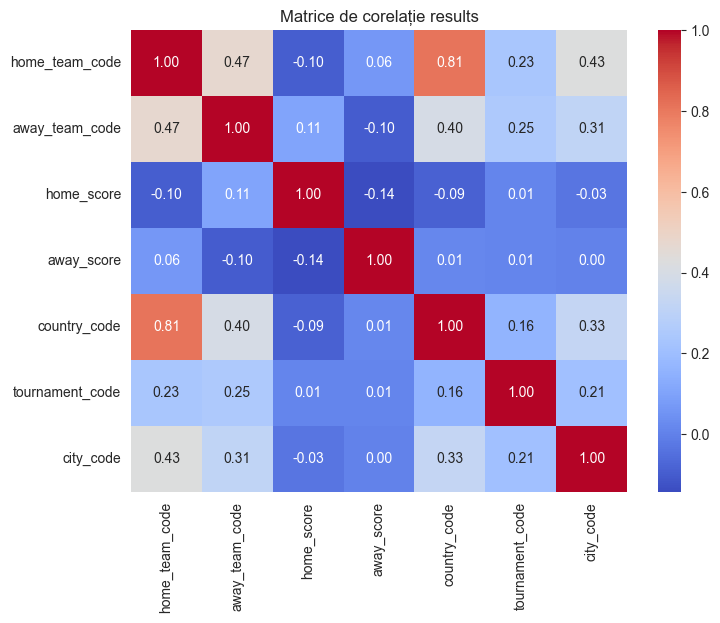

In [6]:
selected_columns = ['home_team_code','away_team_code','home_score','away_score','country_code','tournament_code','city_code']
# Facem un subset-ul doar cu aceste coloane
selected_df = df_results[selected_columns]

correlation_matrix = selected_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corelație results')
plt.show()

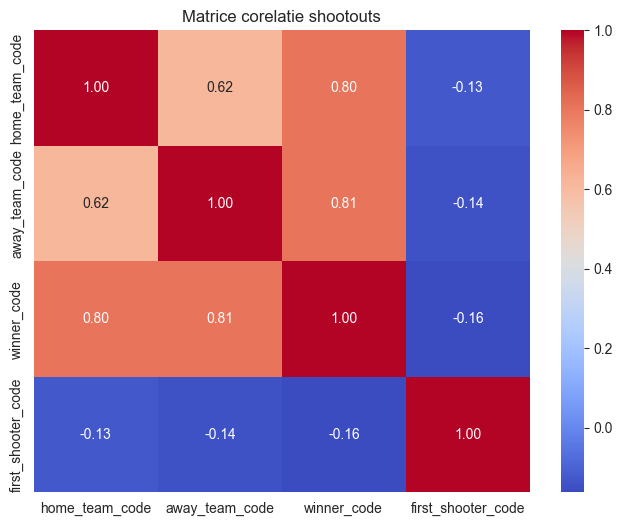

In [7]:
selected_columns_shootouts = ['home_team_code','away_team_code','winner_code','first_shooter_code']
selected_df_shootouts = df_shootouts[selected_columns_shootouts]
correlation_matrix_shootouts = selected_df_shootouts.corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix_shootouts,annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Matrice corelatie shootouts')
plt.show()

In [8]:
# Scorurile echipelor
home_scores = df_results['home_score']
away_scores = df_results['away_score']

# Calculăm Indicele Gini pentru echipele gazdă și oaspete folosind doar scorurile
gini_home = 1 - (2 * (home_scores.value_counts(normalize=True) ** 2).sum())
gini_away = 1 - (2 * (away_scores.value_counts(normalize=True) ** 2).sum())

print("Indicele Gini pentru scorul echipei gazde:", gini_home)
print("Indicele Gini pentru scorul echipei oaspete:", gini_away)

Indicele Gini pentru scorul echipei gazde: 0.5760807080797523
Indicele Gini pentru scorul echipei oaspete: 0.4414442576613685


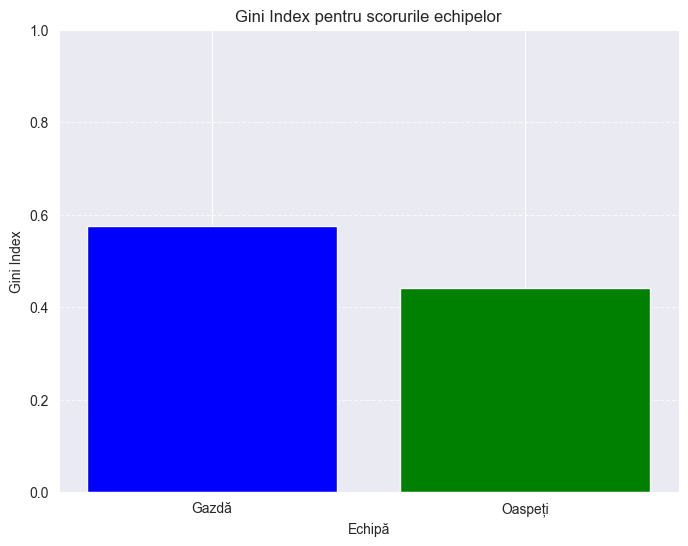

In [9]:
indices = ['Gazdă', 'Oaspeți']
values = [gini_home, gini_away]

plt.figure(figsize=(8, 6))
plt.bar(indices, values, color=['blue', 'green'])
plt.title('Gini Index pentru scorurile echipelor')
plt.xlabel('Echipă')
plt.ylabel('Gini Index')
plt.ylim(0, 1)  # Setarea limitelor axei y între 0 și 1 pentru claritate
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [10]:
# Calculăm Indicele Gini pentru țara gazdă
gini_country = 1 - (2 * (df_results['country'].value_counts(normalize=True) ** 2).sum())

# Calculăm Indicele Gini pentru turneu
gini_tournament = 1 - (2 * (df_results['tournament'].value_counts(normalize=True) ** 2).sum())

# Calculăm Indicele Gini pentru oraș
gini_city = 1 - (2 * (df_results['city'].value_counts(normalize=True) ** 2).sum())

# Pentru neutral
gini_neutral = 1 - (2 * (df_results['neutral'].value_counts(normalize=True) ** 2).sum())

print("Indicele Gini pentru țara gazdă:", gini_country)
print("Indicele Gini pentru turneu:", gini_tournament)
print("Indicele Gini pentru oraș:", gini_city)

Indicele Gini pentru țara gazdă: 0.984399629307436
Indicele Gini pentru turneu: 0.6257598263938469
Indicele Gini pentru oraș: 0.9933110241772799


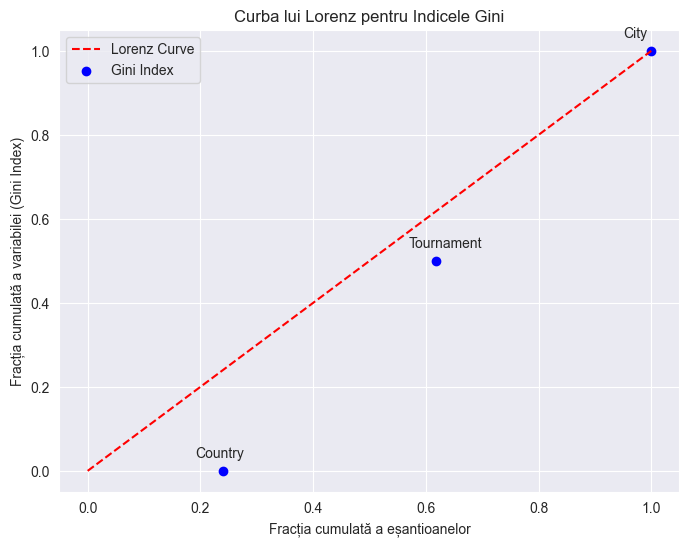

In [11]:
# Indici și etichete
indices = ['Country', 'Tournament', 'City']
values = [gini_country, gini_tournament, gini_city]

# Curba lui Lorenz
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0, 1, len(values)), np.linspace(0, 1, len(values)), label='Lorenz Curve', color='red', linestyle='--')

# Punctele pentru Gini Index
plt.scatter(np.cumsum(sorted(values)) / np.sum(values), np.linspace(0, 1, len(values)), label='Gini Index', color='blue')

# Etichete
for i, txt in enumerate(indices):
    plt.annotate(txt, (np.cumsum(sorted(values))[i] / np.sum(values), np.linspace(0, 1, len(values))[i]), xytext=(-20, 10), textcoords='offset points')

plt.title('Curba lui Lorenz pentru Indicele Gini')
plt.xlabel('Fracția cumulată a eșantioanelor')
plt.ylabel('Fracția cumulată a variabilei (Gini Index)')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Obținem scorurile echipei gazdă 
home_scores = df_results['home_score']

# Calculăm distribuția de frecvență 
frequency_distribution = home_scores.value_counts(normalize=True)

# Calculăm entropia utilizând formula entropiei
entropy_home_scores = -np.sum(frequency_distribution * np.log2(frequency_distribution))

print("Entropia pentru scorurile echipei gazdă:", entropy_home_scores)


Entropia pentru scorurile echipei gazdă: 2.51640087244369


In [13]:
away_scores = df_results['away_score']

frequency_distribution = away_scores.value_counts(normalize=True)

entropy_away_scores = -np.sum(frequency_distribution * np.log2(frequency_distribution))

print("Entropia pentru scorurile echipei oaspete:", entropy_away_scores)

Entropia pentru scorurile echipei oaspete: 2.128400417941539


In [14]:
tournaments = df_results['tournament']

frequency_distribution = tournaments.value_counts(normalize=True)

entropy_tournaments = -np.sum(frequency_distribution * np.log2(frequency_distribution))

print("Entropia pentru turnee:", entropy_tournaments)

Entropia pentru turnee: 3.906636717447083


In [15]:
neutral = df_results['neutral']

frequency_distribution = neutral.value_counts(normalize=True)

# Entropia 
entropy_neutral = -np.sum(frequency_distribution * np.log2(frequency_distribution))

print("Entropia pentru teren neutru:", entropy_neutral)

Entropia pentru teren neutru: 0.8216797449913605


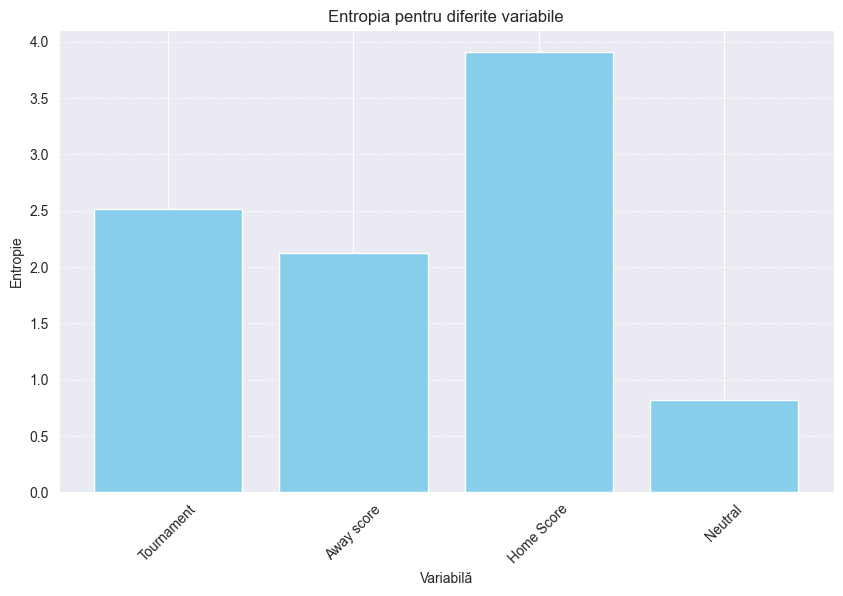

In [16]:
variabile = ['Tournament', 'Away score', 'Home Score', 'Neutral']
entropii = [entropy_home_scores,entropy_away_scores,entropy_tournaments,entropy_neutral]

plt.figure(figsize=(10, 6))
plt.bar(variabile, entropii, color='skyblue')

plt.title('Entropia pentru diferite variabile')
plt.xlabel('Variabilă')
plt.ylabel('Entropie')
plt.xticks(rotation=45)  # Rotim etichetele axei x pentru a le face mai ușor de citit
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afișăm graficul
plt.show()

In [27]:
# Adăugăm o nouă coloană în dataframe care reprezintă scorul total al meciului
df_results['total_score'] = df_results['home_score'] + df_results['away_score']

# Definim caracteristicile (X) și variabila țintă (y)
X = df_results[['home_team_code', 'away_team_code', 'home_score', 'away_score','tournament_code', 'country_code']]
y = df_results['total_score']

# Împărțim datele în set de antrenare și set de testare
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inițializăm modelul KNN cu un număr de vecini (k) ales
knn_model = KNeighborsClassifier(n_neighbors=5)

# Antrenăm modelul pe datele de antrenare
knn_model.fit(X_train, y_train)

# Facem predicții pe datele de testare
y_pred = knn_model.predict(X_test)

# Calculăm acuratețea modelului
accuracy = accuracy_score(y_test, y_pred)
print("Acuratețea modelului KNN:", accuracy)

# Calculăm mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculăm mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


Acuratețea modelului KNN: 0.23439187729531216
Mean Squared Error: 4.941240008641175
Mean Absolute Error: 1.5571397710088573


In [30]:
# Adăugăm o nouă coloană în dataframe care reprezintă scorul total al meciului
df_results['total_score'] = df_results['home_score'] + df_results['away_score']

# Definim caracteristicile (X) și variabila țintă (y)
X = df_results[['home_team_code', 'away_team_code', 'home_score', 'away_score','tournament_code', 'country_code']]
y = df_results['total_score']

# Împărțim datele în set de antrenare și set de testare
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inițializăm modelul Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Antrenăm modelul pe datele de antrenare
rf_model.fit(X_train, y_train)

# Facem predicții pe datele de testare
y_pred_rf = rf_model.predict(X_test)

# Calculăm mean squared error (MSE) și mean absolute error (MAE)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("Mean Squared Error (Random Forest):", mse_rf)
print("Mean Absolute Error (Random Forest):", mae_rf)

Mean Squared Error (Random Forest): 0.0042853316050982925
Mean Absolute Error (Random Forest): 0.002996327500540073
